
# Undersampling k-space: KKI model
Deep learning for undersampled MRI reconstruction
- **Author**: Georgia Kanli
- **Date**: 01/09/2023
- **Purpose**: 2D-Unet - KI 
    - The deep learning model includes 2 components: (1): Under-sampling correction model in k-space domain (2): artefacts correction model in image domain

# **1. Import libraries**

In [1]:
import tensorflow as tf
tf.__version__


2024-11-06 13:35:55.761850: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 13:35:55.783297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 13:35:56.267439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.13.0'

In [2]:
# %reset -f
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
path_start = 'mainFolder/'
sys.path.append(path_start)


import json
import os
import numpy as np

from utils.utilsFun import open_json
from mainFolder.main import run
from mainFolder.dataGeneratorUtils import load_net_partition
    

/home/gkanli/miniconda3/envs/py3.10-tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

# USArt prediction

ModelGenerator: Create model ... 
2DUnet-leakyReLU
****************0.2
************************************
functools.partial(<function compound_l1_mssim_loss at 0x7f8fb60da710>)
************************************
ModelGenerator: Create model ... 
2DUnet
************************************
functools.partial(<function compound_l1_mssim_loss at 0x7f8fb60da710>)
************************************
data/20cases/
Load partition:data/20cases/
data/OriginalData20cases/
(17, 256, 256, 2)
(17, 256, 256, 3)
(17, 256, 256, 2)
ModelGenerator: Prediction ... 


2024-11-06 14:07:38.841266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-06 14:07:39.202598: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


2024-11-06 14:07:40.177917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(17, 256, 256, 2)
0
Before pred: (1, 256, 256)
1/1 [==============================] - 0s 271ms/step
After pred: (1, 256, 256, 1)


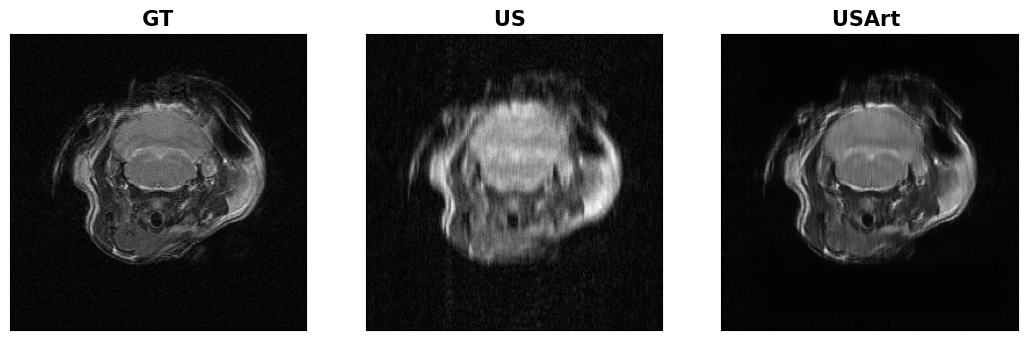

In [9]:
import matplotlib.pyplot as plt
import MRDLin
import mainFolder.dataGeneratorUtils as dataG
import utils.utilsFun as utils
import mainFolder.modelGenerator as modelG

sz = 1
path_result =  './results/' # './resultsGRwithout/'

json_path = path_result + 'Knet/configs.json'
configs_knet = utils.open_json(json_path)
configs_knet.output_dir_base  = path_result
configs_knet.ks_domain  = 'True'

path_model = path_result +  "Knet/saved_model.hdf5"
configs_knet.model = "2DUnet-leakyReLU" # 2DUnet-leakyReLU, 2DUnet, 2DUnet-tanh or complex_cnn
model_knet = modelG.create_model(configs_knet)
model_knet.load_weights(path_model)


json_path = path_result + 'Inet/configs.json'
configs_inet = utils.open_json(json_path)
configs_inet.model = "2DUnet" # 2DUnet-leakyReLU, 2DUnet, 2DUnet-tanh or complex_cnn
configs_inet.output_dir_base  = path_result
configs_inet.ks_domain  = 'False'

path_model = path_result +  "Inet/saved_model.hdf5"
model_inet = modelG.create_model(configs_inet)
model_inet.load_weights(path_model)

# Load partition
path = 'data/20cases/'
print(path)
partition = dataG.load_net_partition(path)    
partition = partition.item()
partition = ['2479-28851-15', '2479-28851-4', '2490-29212-2', '2499-29016-9', '2500-29240-11', '2506-29068-4', '2529-29509-7', '2531-29570-2', '2564-29693-8', '2565-30104-5', '2566-29612-11', '2567-30144-11', '2581-30092-6', '2617-29900-5', '2620-29908-9', '2628-30863-12', '2694-31477-12']



# Load test data
configs_knet.main_data_folder = 'data/OriginalData20cases/'
print(configs_knet.main_data_folder )

x, y = dataG.open_data(configs_knet, partition)
print(np.shape(x))
print(np.shape(y))
mask = y[:,:,:,2]
y = y[:,:,:,0:2]
print(np.shape(y))

# prediction
prediction_matrix_knet = modelG.prediction(x, model_knet)
prediction_matrix_knet = prediction_matrix_knet[:,:,:,0:2]
print(np.shape(prediction_matrix_knet))
# sz = np.shape(prediction_matrix_knet)[0]


gt_ks = np.zeros((sz,np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
gt_im = np.zeros((sz,np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
x_ks_knet = np.zeros((sz,np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
x_im_knet = np.zeros((sz,np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
x_pre_im_knet = np.zeros((sz,np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
for i in range(0,sz):
    print(i)
    # GT
    buffer = np.zeros((np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
    buffer[:, :].real = np.squeeze(y[i, :, :, 0])
    buffer[:, :].imag = np.squeeze(y[i, :, :, 1])
    gt_ks[i,:,:] = buffer
    gt_im[i,:,:] = MRDLin.recon_corrected_kspace(gt_ks[i,:,:])
    
    # Knet input
    buffer = np.zeros((np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
    buffer[:, :].real = np.squeeze(x[i, :, :, 0])
    buffer[:, :].imag = np.squeeze(x[i, :, :, 1])
    x_ks_knet[i,:,:] = buffer
    x_im_knet[i,:,:] = np.abs(MRDLin.recon_corrected_kspace(x_ks_knet[i,:,:]))
    
    # Knet output
    x_plot = np.empty((np.shape(x)[1],np.shape(x)[2],2))
    mask_new = np.zeros((np.shape(mask)[1], np.shape(mask)[2], 2))
    mask_new[:, :, 0] = mask[i, :, :]
    mask_new[:, :, 1] = mask[i, :, :]
    x_pre_ks_knet = prediction_matrix_knet[i, :, :, :]
    x_plot = x_pre_ks_knet * (1 - mask_new) + x[i, :, :, :] * mask_new
    kspace_or = np.zeros((np.shape(x)[1],np.shape(x)[2]), dtype='complex128')
    kspace_or[:, :].real = np.squeeze(x_plot[:, :, 0])
    kspace_or[:, :].imag = np.squeeze(x_plot[:, :, 1])
    x_pre_im_knet[i,:,:] = np.abs(MRDLin.recon_corrected_kspace(kspace_or))

# Inet output
prediction_matrix_inet = dataG.prediction(np.abs(x_pre_im_knet), model_inet)
prediction_matrix_inet = prediction_matrix_inet

for i_img in range(0, sz):
    fig = plt.figure(figsize=(13, 7))

    # k-space domain
    plt.subplot(1, 3, 1)
    plt.imshow(np.abs(gt_im[i_img, :, :]), cmap='gray')
    plt.title(' GT ', fontweight="bold", fontsize=15)
    plt.xticks([])
    plt.yticks([])

    # image domain
    plt.subplot(1, 3, 2)
    plt.imshow(np.abs(x_im_knet[i_img, :, :]), cmap='gray')
    plt.title('US ', fontweight="bold", fontsize=15)
    plt.xticks([])
    plt.yticks([])    

    # image domain
    plt.subplot(1, 3, 3)
    plt.imshow(prediction_matrix_inet[i_img, :, :, 0], cmap='gray')
    plt.title('USArt ', fontweight="bold", fontsize=15)
    plt.xticks([])
    plt.yticks([])
